## Imports:

In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
from numpy.linalg import svd

## Camera parameters:

In [16]:
# camera baselines (intel realsense D435)
HFOV=90 #degrees
Xres=848 #pixels
baseline=50 #mm
f = 0.5*(Xres/np.tan(HFOV/2)) #pixels

## Loading in images and plotting functions:

In [22]:
def plot_matching_features(f1, f2, im1, im2):
    image1, image2 = im1.copy(), im2.copy()
    
    for f in f1:
        image1 = cv2.circle(image1, (int(f[0]),int(f[1])), 1, (255,255,0), 2)
    for f in f2:
        image2 = cv2.circle(image2, (int(f[0]),int(f[1])), 1, (255,255,0), 2)
        
    fig, ax = plt.subplots(1,2, figsize=(15,10))
    
    ax[0].imshow(image1)
    ax[0].axis("off")
    ax[0].set_title("Left Image")
    ax[1].imshow(image2)
    ax[1].axis("off")
    ax[1].set_title("Right Image")
    plt.show()

In [23]:
def plot_shift_features(f1,f2,im1):
    # from left image we show change to points in right
    image1 = im1.copy()
    
    for l, r in zip(f1, f2):
        image1 = cv2.line(image1, (int(l[0]),int(l[1])), (int(r[0]),int(r[1])), (255,0,0), 2)
    
    plt.figure(figsize=(12,7))
    plt.imshow(image1)
    plt.axis("off")
    plt.title("Change in points from left to right image")
    plt.show()

## SIFT feature finding:

In [24]:
def feature_matching(img0, img1):
    img_1_sift = img0.copy()
    img_2_sift = img1.copy()
    
    img_1_sift = cv2.resize(img_1_sift,(640,480),fx=0,fy=0,interpolation=cv2.INTER_AREA)
    img_2_sift = cv2.resize(img_2_sift,(640,480),fx=0,fy=0,interpolation=cv2.INTER_AREA)
    
    sift = cv2.SIFT_create()
    
    keypoints_1, descriptors_1 = sift.detectAndCompute(img_1_sift,None)
    keypoints_2, descriptors_2 = sift.detectAndCompute(img_2_sift,None)
    
    
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
    
    matches = bf.match(descriptors_1, descriptors_2)
    matches = sorted(matches, key = lambda x:x.distance)
    
    features_1 = []
    features_2 = []
    for i in matches:
        features_1.append(keypoints_1[i.queryIdx].pt)
        features_2.append(keypoints_2[i.trainIdx].pt)

    return features_1, features_2, img_1_sift, img_2_sift

## Finding the best F matrix using RANSAC:

In [25]:
# using ransac to find the best points (and to find the 8 best points that make the best fundamental matrix)

In [26]:
def RANSAC_best_Fundamental(img_1_features, img_2_features):
   
    #RANSAC parameters
    N = 2000
    sample = 0
    thresh = 0.05
    inliers_atm = 0
    P = 0.99
    R_fmat = []

    # run loop 2000 times to find the best points
    while sample < N:
        
        rand_p1 = [] ; rand_p2 = []
        
        # getting a set of random 8 points
        index = np.random.randint( len(img_1_features) , size = 8)
        
        for i in index:
            
            rand_p1.append(img_1_features[i])
            rand_p2.append(img_2_features[i])
        
        Fundamental = F_matrix(rand_p1, rand_p2)
        
        # Hartley's 8 points algorithm
        ones = np.ones((len(img_1_features),1))
        x_1 = np.concatenate((img_1_features,ones),axis=1)
        x_2 = np.concatenate((img_2_features,ones),axis=1)
        # x_1 and x_2 put it into (x, y, 1) for timsing against F
        
        # finds error of each point pair and determines if they are inliers or not (the F with most inliers will be kept as the best F matrix)
        line_1 = np.dot(x_1, Fundamental.T)
        
        line_2 = np.dot(x_2,Fundamental)
    
        e1 = np.sum(line_2* x_1,axis=1,keepdims=True)**2
        
        e2 = np.sum(np.hstack((line_1[:, :-1],line_2[:,:-1]))**2,axis=1,keepdims=True)
        
        error =  e1 / e2 
        
        inliers = error <= thresh
         
        inlier_count = np.sum(inliers)
        
        #estimating best Fundamental M
        if inliers_atm <  inlier_count:
            
            inliers_atm = inlier_count
            
            good_ones = np.where(inliers == True)
            
            x_1_pts = np.array(img_1_features)
            x_2_pts = np.array(img_2_features)
            
            in_points_x1 = x_1_pts[good_ones[0][:]]
            in_points_x2 = x_2_pts[good_ones[0][:]]

            R_fmat = Fundamental
            
        #iterating for N number of times
        inlier_ratio = inlier_count/len(img_1_features)
        
        denominator = np.log(1-(inlier_ratio**8))
        
        numerator = np.log(1-P)
        
        if denominator == 0: continue
        N =  numerator / denominator
        sample += 1
        
    return R_fmat, in_points_x1, in_points_x2

In [27]:
def F_matrix(f1, f2): # takes in 8 feature points from each left and right image and outputs fundamental matrix
    
    # setting arrays
    f1_x = [] ; f1_y = [] ; f2_x = [] ; f2_y = []

    f1 = np.asarray(f1)
    f2 = np.asarray(f2)

    # normalizing features (centereing them at (0,0) and between [-1,1])
    # goes under a transformation T: F-hat = T.T^-1*F*T^-1 >>> F = T.T*F-hat*T (have to unnormalize later on)
    f1_x_mean = np.mean(f1[:,0])    
    f1_y_mean = np.mean(f1[:,1])    
    f2_x_mean = np.mean(f2[:,0])        
    f2_y_mean = np.mean(f2[:,1])
    
    # centers values at (0,0)
    for i in range(len(f1)): f1[i][0] = f1[i][0] - f1_x_mean
    for i in range(len(f1)): f1[i][1] = f1[i][1] - f1_y_mean
    for i in range(len(f2)): f2[i][0] = f2[i][0] - f2_x_mean
    for i in range(len(f2)): f2[i][1] = f2[i][1] - f2_y_mean

    f1_x = np.array(f1[:,0])
    f1_y = np.array(f1[:,1])
    f2_x = np.array(f2[:,0])
    f2_y = np.array(f2[:,1])
    
    sum_f1 = np.sum((f1)**2, axis = 1)
    sum_f2 = np.sum((f2)**2, axis = 1)
    
    k_1 = np.sqrt(2.)/np.mean(sum_f1**(1/2))
    k_2 = np.sqrt(2.)/np.mean(sum_f2**(1/2))

    s_f1_1 = np.array([[k_1,0,0],[0,k_1,0],[0,0,1]])
    s_f1_2 = np.array([[1,0,-f1_x_mean],[0,1,-f1_y_mean],[0,0,1]])

    s_f2_1 = np.array([[k_2,0,0],[0,k_2,0],[0,0,1]])
    s_f2_2 = np.array([[1,0,-f2_x_mean],[0,1,-f2_y_mean],[0,0,1]])
    
    # transformation matrix for unnormalizing later on
    t_1 = np.dot(s_f1_1,s_f1_2)
    t_2 = np.dot(s_f2_1,s_f2_2)
    
    # places values between [-1,1]
    x1 = ( (f1_x).reshape((-1,1)) ) * k_1
    y1 = ( (f1_y).reshape((-1,1)) ) * k_1
    x2 = ( (f2_x).reshape((-1,1)) ) * k_2
    y2 = ( (f2_y).reshape((-1,1)) ) * k_2
    
    # creating A using Kronecker product (np.dot(A,F) = 0), which allows us to use an svd to find F
    Alist = []
    for i in range(x1.shape[0]):
        X1, Y1 = x1[i][0],y1[i][0]
        X2, Y2 = x2[i][0],y2[i][0]
        Alist.append([X2*X1, X2*Y1, X2, Y2*X1, Y2*Y1 , Y2 , X1 , Y1, 1])
    A = np.array(Alist) # 8x9 matrix
    
    # using svd and redoing svd with rank 2 constraint to find F (normalized)
    U, sigma, VT = svd(A) # first svd
    
    f_val = VT.T[:,-1] # grab the last column of V as it is F
    f_mat = f_val.reshape((3,3))
    
    Uf, sigma_f, Vf = np.linalg.svd(f_mat) # redo svd with F
    
    sigma_f[-1] = 0 # forcing the rank 2 constraint
    sigma_final = np.zeros(shape=(3,3)) 
    sigma_final[0][0] = sigma_f[0] 
    sigma_final[1][1] = sigma_f[1] 
    sigma_final[2][2] = sigma_f[2]
    
    # un-normalizing 
    f_main = np.dot(Uf , sigma_final)
    f_main = np.dot(f_main , Vf)
    
    f_unnorm = np.dot(t_2.T , f_main)
    f_unnorm = np.dot(f_unnorm , t_1)
    f_unnorm = f_unnorm/f_unnorm[-1,-1]
    
    return f_unnorm

In [28]:
# essential matrix using camera calibration matrices cam0 and cam1 and F (I wont use as I havent calibrated camera)
def E_matrix(F_matrix):
    
    e_mat = np.dot(cam1.T,F_matrix)
    e_mat = np.dot(e_mat,cam0)
    
    #solving for E using SVD
    Ue, sigma_e, Ve = np.linalg.svd(e_mat)
    sigma_final = np.zeros((3,3))
    
    for i in range(3):
        sigma_final[i,i] = 1
    sigma_final[-1,-1] = 0

    E_mat = np.dot(Ue,sigma_final)
    E_mat = np.dot(E_mat,Ve)
    
    return E_mat

## Finding epipolar lines:

In [29]:
# function to draw the epipolar lines on the given images
def drawlines(drawline_im1, drawline_im2, lines, pts1, pts2):
   
    sh = drawline_im1.shape
    r = sh[0]
    c = sh[1]
    
    for r, pt1, pt2 in zip(lines,pts1,pts2):
        pt1 = [int(pt1[0]),int(pt1[1])]
        pt2 = [int(pt2[0]),int(pt2[1])]
        
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        drawline_im1 = cv2.line(drawline_im1, (x0,y0), (x1,y1), color,1)
        drawline_im1 = cv2.circle(drawline_im1,tuple(pt1),2,color,-1)
        drawline_im2 = cv2.circle(drawline_im2,tuple(pt2),2,color,-1)
        
    return drawline_im1, drawline_im2

## Finding 2 homography matrices (left and right image)

In [31]:
#least squares technique
def least_squares(x_1_ls, x_2_ls):
    
    lis = list()

    #forming the X matrix
    X = x_1_ls
    Y = np.reshape(x_2_ls, (x_2_ls.shape[0], 1))

    #computing B matrix 
    X_total = np.dot(X.T, X)
    X_total_inv = np.linalg.inv(X_total)
    Y_total = np.dot(X.T, Y)
    B_mat = np.dot(X_total_inv, Y_total)

    #computing the y coordinates and forming a list to return
    new_y = np.dot(X, B_mat)
    for i in new_y:
        for a in i:
            lis.append(a)

    return B_mat

In [32]:
# rectification function to get the homography matrices
def to_rectify(F_mat, points1, points2):
    
    points1 = np.asarray(points1)
    points2 = np.asarray(points2)
    
    # epipoles of left and right images
    U, sigma, VT = np.linalg.svd(F_mat)
    V = VT.T
    s = np.where(sigma < 0.00001)
    
    e_left = V[:,s[0][0]]
    e_right = U[:,s[0][0]]
    
    e_left = np.reshape(e_left,(e_left.shape[0],1))
    e_right = np.reshape(e_right,(e_right.shape[0],1))
    
    T_1 = np.array([[1,0,-(640/2)],[0,1,-(480/2)],[0,0,1]])
    e_final = np.dot(T_1,e_right)
    e_final = e_final[:,:]/e_final[-1,:]
    
    len = ((e_final[0][0])**(2)+(e_final[1][0])**(2))**(1/2)
    
    if e_final[0][0] >= 0:
        
        alpha = 1
    else:
        
        alpha = -1
        
    T_2 = np.array([[(alpha*e_final[0][0])/len, (alpha*e_final[1][0])/len, 0],
                    [-(alpha*e_final[1][0])/len, (alpha*e_final[0][0])/len, 0],[0, 0, 1]])
    e_final = np.dot(T_2,e_final)
    
    T_3 = np.array([[1, 0, 0],[0, 1, 0],[((-1)/e_final[0][0]), 0, 1]])
    e_final = np.dot(T_3,e_final)
    
    PHI2 = np.dot(np.dot(np.linalg.inv(T_1),T_3),np.dot(T_2,T_1))

    h_ones = np.array([1,1,1])
    h_ones = np.reshape(h_ones,(1,3))
    
    z = np.array([[0,-e_left[2][0],e_left[1][0]],[e_left[2][0],0,
                                -e_left[0][0]],[-e_left[1][0],e_left[0][0],0]])
    
    M = np.dot(z,F_mat) + np.dot(e_left,h_ones)

    Homography = np.dot(PHI2,M)
    
    ones = np.ones((points1.shape[0],1))
    points_1 = np.concatenate((points1,ones), axis = 1)
    points_2 = np.concatenate((points2,ones), axis = 1)
    
    x_1 = np.dot(Homography,points_1.T)
    x_1 = x_1[:,:]/x_1[2,:]
    x_1 = x_1.T
    
    x_2 = np.dot(PHI2,points_2.T)
    x_2 = x_2[:,:]/x_2[2,:]
    x_2 = x_2.T
    
    x_2_dash = np.reshape(x_2[:,0], (x_2.shape[0],1))
    
    L_S = least_squares(x_1,x_2_dash)
    
    d_1 = np.array([[L_S[0][0],L_S[1][0],L_S[2][0]],[0,1,0],[0,0,1]])
    
    PHI1 = np.dot(np.dot(d_1,PHI2),M)
    
    return PHI1,PHI2


## Calculate disparity (searching similar pixels points across horizontal lines)

In [33]:
# sum of absolute difference 
def s_abs_diff(pixel_vals_1, pixel_vals_2):

    if pixel_vals_1.shape != pixel_vals_2.shape:
        return -1
    return np.sum(abs(pixel_vals_1 - pixel_vals_2))

In [34]:
# compare left block of pixels with multiple blocks from the right image using 
def window_compare(y, x, left_local, right, window_size=5):
    
    local_window = 20
    
    # get search range for the right image
    x_min = max(0, x - local_window)
    x_max = min(right.shape[1], x + local_window)
    min_sad = None
    index_min = None
    first = True
    
    # only compare to points in the x row as we have reduced search space
    for x in range(x_min, x_max):
        right_local = right[y: y+window_size,x: x+window_size]
        sad = s_abs_diff(left_local, right_local)
        if first:
            min_sad = sad
            index_min = (y, x)
            first = False
        else:
            if sad < min_sad:
                min_sad = sad
                index_min = (y, x)

    return index_min

In [35]:
#disparity calculation on the recified images
def disparity_calc(image_left, image_right):
    
    window = 5

    left = np.asarray(image_left)
    right = np.asarray(image_right)
    
    left = left.astype(int)
    right = right.astype(int)
    
    if left.shape != right.shape:
        print("Image Shapes do not match!!")
      
    h, w, g = left.shape
    
    disparity = np.zeros((h, w))
    # going over each pixel
    for y in range(window, h-window):
        for x in range(window, w-window):
            left_local = left[y:y + window, x:x + window]
            index_min = window_compare(y, x, left_local, right, window_size = window)
            disparity[y, x] = abs(index_min[1] - x)
            
    plt.imshow(disparity, cmap='jet')
    plt.colorbar()
    plt.title('Disparity Plot Heat')
    plt.show()
    
    return disparity

## Calculate depth:

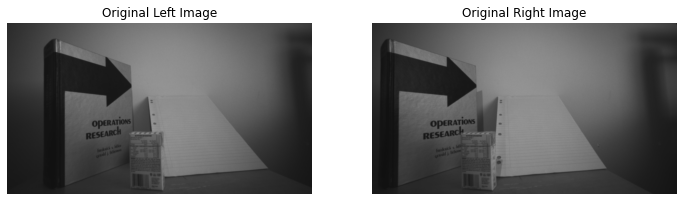

Finding SIFT features:


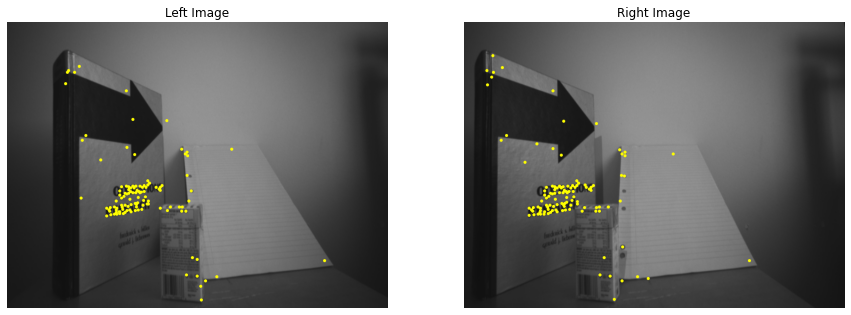

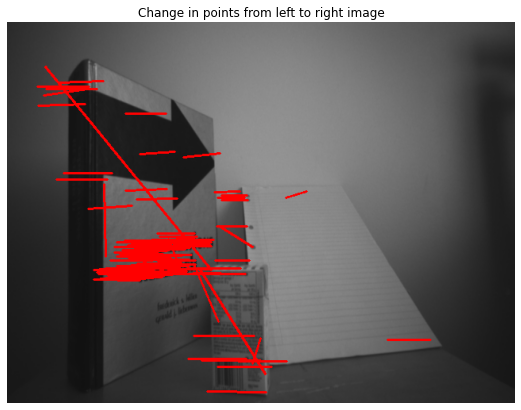

Removing outlier features with RANSAC:


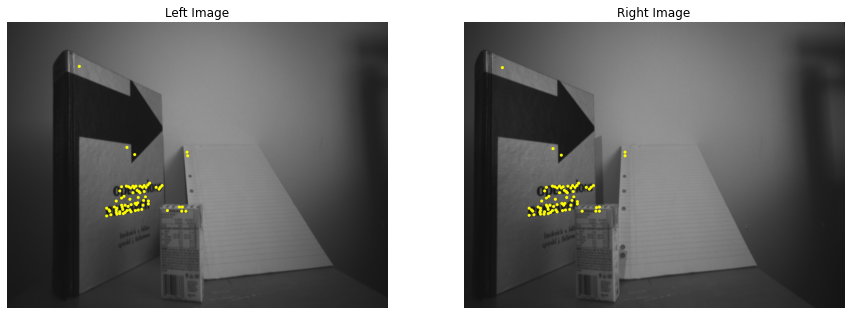

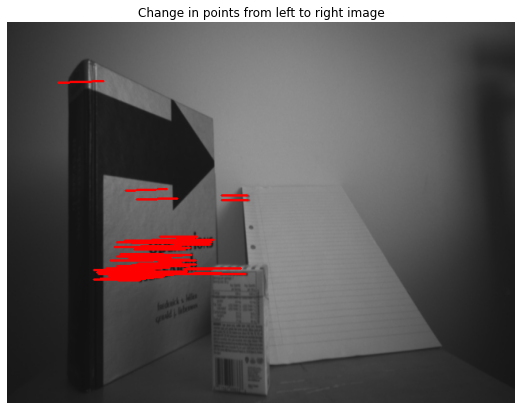

Computing Epipolar lines:


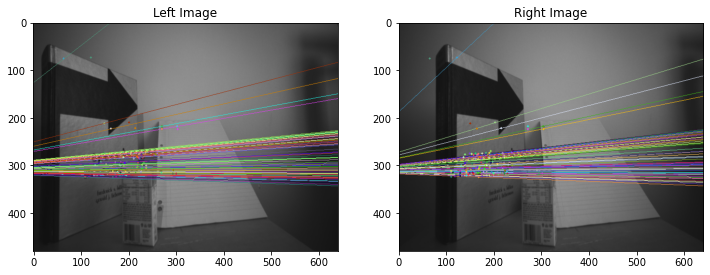

Computing Homography matrix for warping images:
Homography Mat 1 : 
 [[-4.93645973e-01  6.42915785e-02  6.33319305e+01]
 [-1.56645119e-01 -1.51848241e-01 -3.65447398e+00]
 [-4.97669221e-04 -5.38283246e-04  5.86460090e-03]]

Homography Mat 2 : 
 [[ 1.55589062e+00 -2.03415666e-01 -1.29065238e+02]
 [ 5.52882543e-01  9.36226799e-01 -1.61616846e+02]
 [ 1.76352796e-03 -2.30561974e-04  4.91005927e-01]]
Perspective Warping Images:


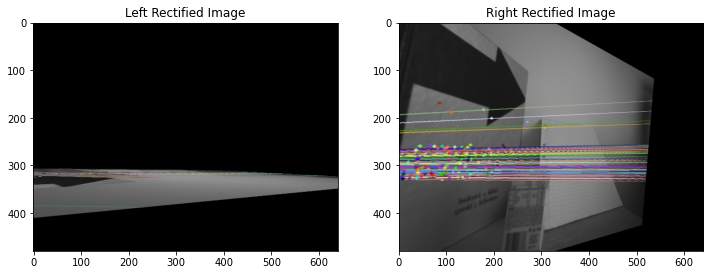

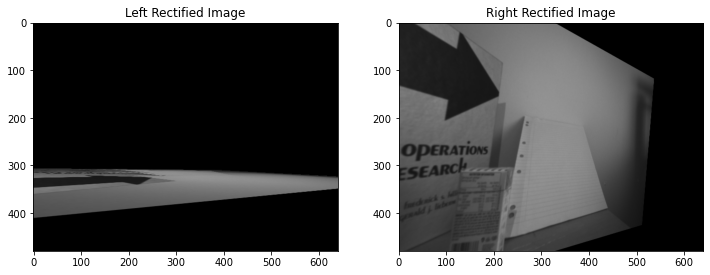

Calculating Disparity:


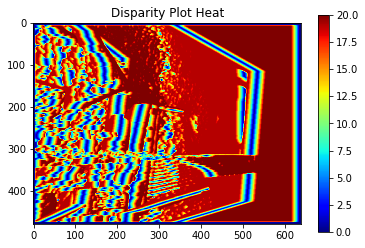

In [50]:
# load images in (left and right)
i = 122
img0 = cv2.imread("Images/Image{}.png".format(i+1))
img1 = cv2.imread("Images/Image{}.png".format(i))
fig, ax = plt.subplots(1,2,figsize=(12,7))
ax[0].imshow(img0)
ax[0].set_title("Original Left Image")
ax[0].axis("off")
ax[1].imshow(img1)
ax[1].set_title("Original Right Image")
ax[1].axis("off")
plt.show()

# find SIFT features
print("Finding SIFT features:")
f1, f2, im1, im2 = feature_matching(img0, img1)
plot_matching_features(f1,f2,im1,im2)
plot_shift_features(f1,f2,im1)

# remove outliers and solve F matrix
print("Removing outlier features with RANSAC:")
best_f_matrix, r_points_1, r_points_2 = RANSAC_best_Fundamental(f1, f2)
plot_matching_features(r_points_1,r_points_2,im1,im2)
plot_shift_features(r_points_1,r_points_2,im1)

# copy images for drawing on
img_1_copy1 = im1.copy()
img_2_copy1 = im2.copy()

# compute and draw epipolar lines
print("Computing Epipolar lines:")
epilines_1 = cv2.computeCorrespondEpilines(r_points_2.reshape(-1,1,2), 2, best_f_matrix)
epilines_1 = epilines_1.reshape(-1,3)

epilines_2 = cv2.computeCorrespondEpilines(r_points_1.reshape(-1,1,2), 1,best_f_matrix)
epilines_2 = epilines_2.reshape(-1,3)

img1, img2 = drawlines(im1, im2, epilines_1, r_points_1[:100], r_points_2[:100])
img1, img2 = drawlines(im2, im1, epilines_2, r_points_1[:100], r_points_2[:100])

fig, ax = plt.subplots(1,2,figsize=(12,7))
ax[0].imshow(img1)
ax[0].set_title("Left Image")
ax[1].imshow(img2)
ax[1].set_title("Right Image")
plt.show()

# putting points into (x, y, 1) form
one_s = np.ones((r_points_1.shape[0],1))
r_points_1 = np.concatenate((r_points_1,one_s),axis = 1)
r_points_2 = np.concatenate((r_points_2,one_s),axis = 1)

# computing homography: I dont reaaly understand what they did in this section to find the 2 homography matrices
print("Computing Homography matrix for warping images:")
Hom_0 , Hom_1 = to_rectify(best_f_matrix, f1, f2)
print('Homography Mat 1 : \n', Hom_0)
print('\nHomography Mat 2 : \n', Hom_1)

# warp images based off homography matrices: new img1 coords = H1 x (old img1 coords)
print("Perspective Warping Images:")
left_rectified = cv2.warpPerspective(img1, Hom_0, (640,480))
right_rectified = cv2.warpPerspective(img2, Hom_1, (640,480))

left_rec_nolines = cv2.warpPerspective(img_1_copy1, Hom_0, (640,480))
right_rec_nolines = cv2.warpPerspective(img_2_copy1, Hom_1, (640,480))

fig, ax = plt.subplots(1,2,figsize=(12,7))
ax[0].imshow(left_rectified)
ax[0].set_title("Left Rectified Image")
ax[1].imshow(right_rectified)
ax[1].set_title("Right Rectified Image")
plt.show()

fig, ax = plt.subplots(1,2,figsize=(12,7))
ax[0].imshow(left_rec_nolines)
ax[0].set_title("Left Rectified Image")
ax[1].imshow(right_rec_nolines)
ax[1].set_title("Right Rectified Image")
plt.show()

# calc disparity
print("Calculating Disparity:")
disparity = disparity_calc(left_rec_nolines, right_rec_nolines)

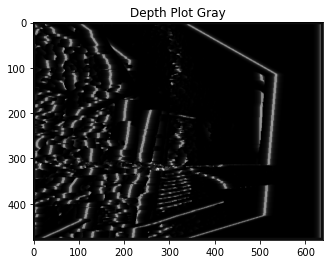

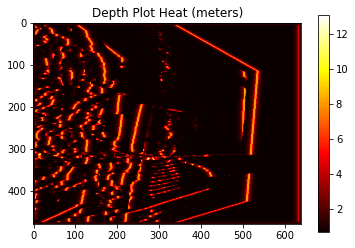

In [51]:
disp = disparity.copy()

# to stop disp = 0 (cant divide by 0)
disp[disp==0] = 10

depth = baseline * f / disp

# depth is in mm (change to m)
depth = depth/(1000)

plt.imshow(depth, cmap='gray', interpolation='bilinear')
plt.title('Depth Plot Gray')
plt.show()

plt.imshow(depth, cmap='hot')
plt.colorbar()
plt.title('Depth Plot Heat (meters)')
plt.show()